In [1]:
%matplotlib inline 
import pandas as pd 
import numpy as np 
import peak_analist as pk
import copy 
import pylab as pl 
import glob 
import matplotlib.patches as mpatches
from string import Template

In [2]:
rivers = {
    'turkey': {
        'id':'05412500',
        'skew':-0.4,
        'area':4000,
        'name':'Turkey River',
        'years':[102, 50]
    },
    'cedar': {
        'id':'05464500',
        'skew':-0.4,
        'area':16000,
        'name':'Cedar River',
        'years':[119, 50]
    },
    'salt': {
        'id':'05452000',
        'skew':-0.3437,
        'area':500,
        'name':'Salt Creek',
        'years':[76, 50]
    },
    'NorthRacoon': {
        'id':'05482500',
        'skew':-0.3919,
        'area':2500,
        'name':'North Raccoon',
        'years':[79, 50]
    },
}

## Work to perform:

1. Run each case with 1000 realizations for all the records and for 50 years 
    1.1. For all the records case just run the Error Ind and the Error dep cases. 
    1.2. For the 50 years include the sampling and E+S cases 
2. Figure 3, redo with the 1000 realizations for the 50 years case 
3. Figure 4, redo with first row all the records (only EI and ED) and second row with 50 years including EI+S and S
4. Figure 5, redo
5. Figure 6, All vs all, do it but first row will show for all the records P(RD<10%) and the second row for 50 years P(RD<10%)


To have into account regarding the watflow peak flows 
- code 2 next to the peakflow indicates that it is an estimate (large error)
- code 7 is an historic peak 
- code 6 is a regulation or diversion
- code 1 in line 55 indicates affected by backwater 
- code 2 in line 55 indicates that it is not the maximum of the year 



## Runs names conventions

- EI: Error Inedependent 
- ED: Error Dependent of magnitude 
- S: Sampling (apply only to 50y)
- SEI: Sampling and Error Independent (apply only to 50y)


# Create the time series with $\sigma^2$ dependent on the magnitude 

In [25]:
for river in rivers.keys():
    peaks_file = '{id}f-{name}.txt'.format(**{'id':rivers[river]['id'], 'name':river})
    for year in rivers[river]['years']:
        out_files = '{name}_{years}y_NoiseDep'.format(**{'name':river, 'years': year})        
        a = pk.write_mutated_peaks(peaks_file, out_files+'.txt', out_files+'.psf', out_files+'.prt',
                                  year, 100, rivers[river]['skew'], 0.55, 0.16, method='EMS', 
                                  error = 0.1, add_noise=True)

# Manuscript Figures 

## Figure 3: Contrasting FFE for North Raccoon using the four strategies 

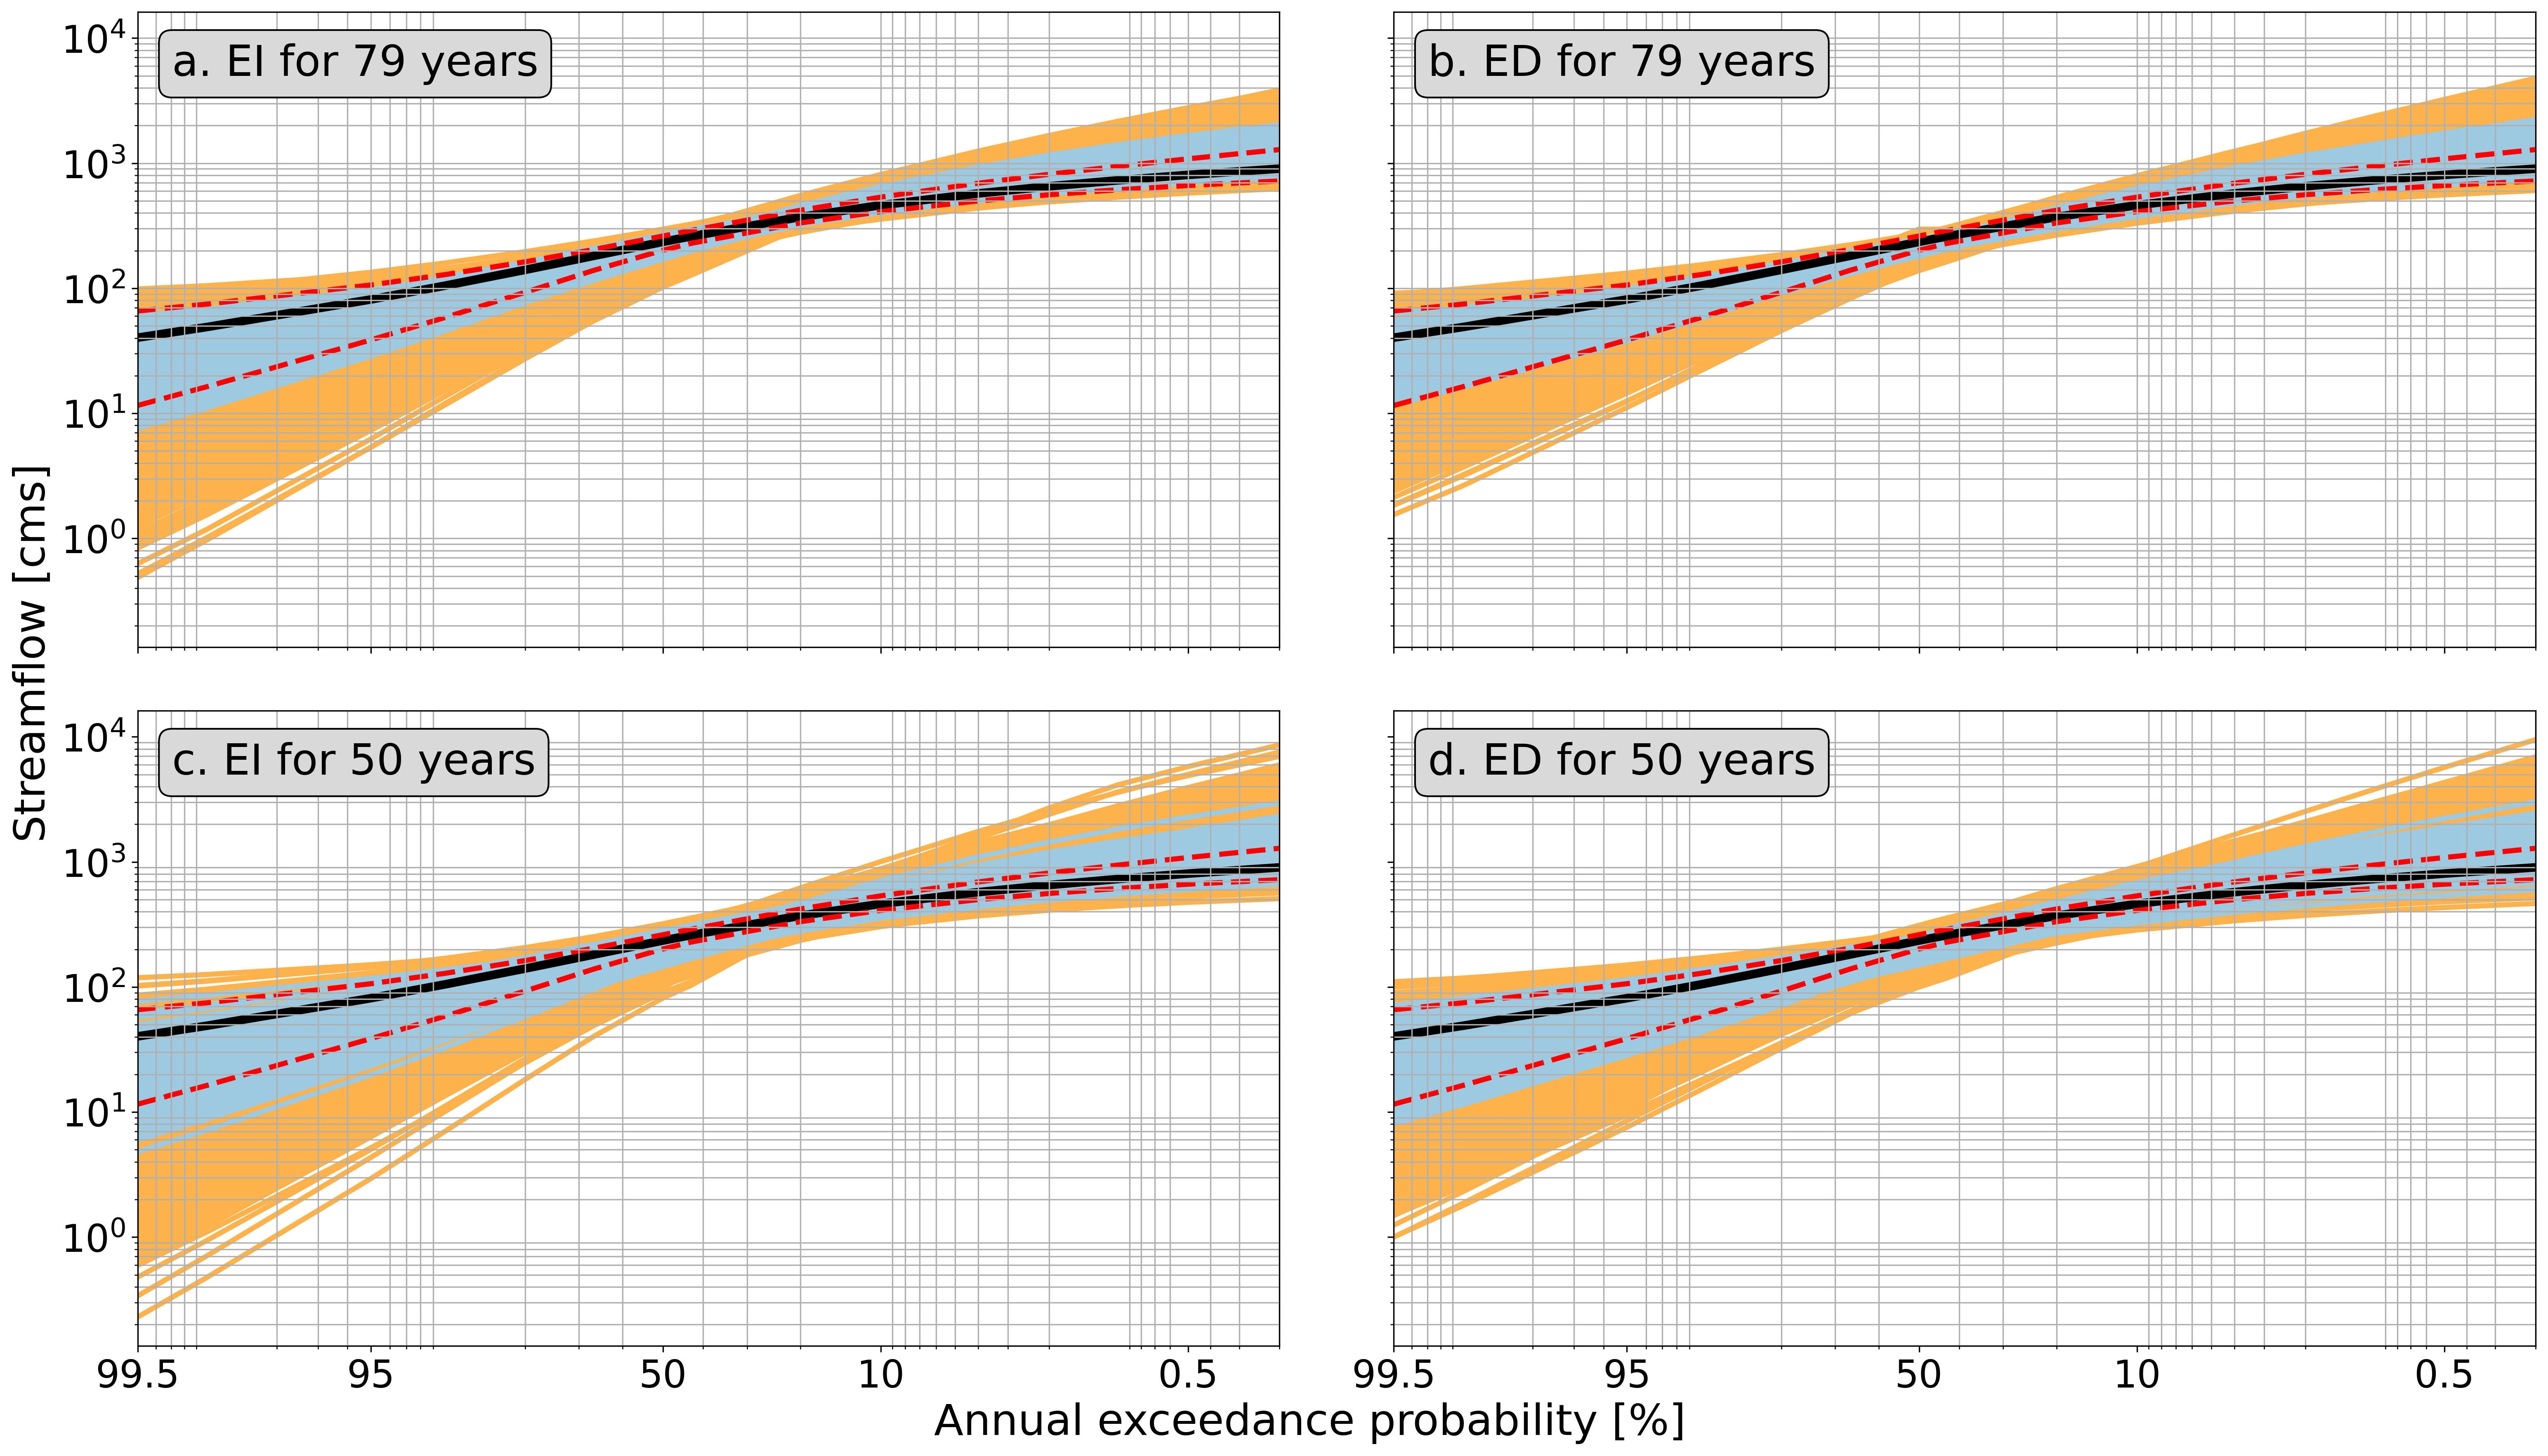

In [3]:
do = pk.read_prt('data/05482500F-NORTHRACOON.PRT')[0]
q,ema,p = pk.read_obs('data/05482500F-NORTHRACOON.PRT')

fig, ax = pl.subplots(2,2,figsize = (25,14), sharey=True, sharex=True, dpi = 300)


dn = pk.read_prt('data/sim/NORTHRACOON_79Y_EI.PRT')
a = pk.plot_freq(do, ax[0][0], dn)
a.legend().set_visible(False)
a.set_xlabel('')
a.set_ylabel('')
a.set_xticks([0.005,0.05,0.5,0.9,0.995])
a.set_xticklabels([99.5,95,50,10,0.5])
a.text(0.03,0.9,'a. EI for 79 years', transform = a.transAxes, bbox = dict(boxstyle='round', fc = '#d9d9d9'), size = 25)

dn = pk.read_prt('data/sim/NORTHRACOON_79Y_ED.PRT')
a = pk.plot_freq(do, ax[0][1], dn)
a.legend().set_visible(False)
a.set_ylabel('')
a.set_xlabel('')
a.set_xticks([0.005,0.05,0.5,0.9,0.995])
a.set_xticklabels([99.5,95,50,10,0.5])
a.text(0.03,0.9,'b. ED for 79 years', transform = a.transAxes, bbox = dict(boxstyle='round', fc = '#d9d9d9'), size = 25)

dn = pk.read_prt('data/sim/NORTHRACOON_50Y_EI.PRT')
a = pk.plot_freq(do, ax[1][0], dn)
a.legend().set_visible(False)
a.set_ylabel('                                                       Streamflow [cms]', size = 25)
a.set_xlabel('                                                                                        Annual exceedance probability [%]', size = 25)
a.set_xticks([0.005,0.05,0.5,0.9,0.995])
a.set_xticklabels([99.5,95,50,10,0.5])
a.text(0.03,0.9,'c. EI for 50 years', transform = a.transAxes, bbox = dict(boxstyle='round', fc = '#d9d9d9'), size = 25)
a.grid(which = 'major')

dn = pk.read_prt('data/sim/NORTHRACOON_50Y_ED.PRT')
a = pk.plot_freq(do, ax[1][1], dn)
a.legend().set_visible(False)
a.set_ylabel('')
a.set_xlabel('')
a.set_xticks([0.005,0.05,0.5,0.9,0.995])
a.set_xticklabels([99.5,95,50,10,0.5])
a.text(0.03,0.9,'d. ED for 50 years', transform = a.transAxes, bbox = dict(boxstyle='round', fc = '#d9d9d9'), size = 25)
a.grid(which = 'major')


pl.subplots_adjust(wspace = 0.1, hspace = 0.1)
pl.savefig('figures/Fig3_FFE_Examples.png', bbox_inches = 'tight')

## Figure 4: Relative difference on the means 

The following must be run just once, then It can be replaced by the next cell

In [33]:
for r in ['cedar', 'salt', 'NorthRacoon']:
    #Read the observed FFE
    try:
        do = pk.read_prt('data/{id}F-{name}.PRT'.format(**{'id':rivers[r]['id'], 'name':r.upper()}))[0]
    except:
        do = pk.read_prt('data/{id}F_{name}.PRT'.format(**{'id':rivers[r]['id'], 'name':r.upper()}))[0]
    #Compute the ratios and the relative differences 
    all_ratios,all_mse, stats = pk.ratios4cases_of_gauge('data/sim/{name}_*'.format(**{'name':r.upper()}), do)
    rivers[r].update({'ratios':all_ratios, 'rd':all_mse,'stats':stats})
    for k in all_mse.keys():
        s = str(k)
        try:
            np.savez('data/processed/rel_diff_%s_%s.npz' % (r,s),**all_mse[k]['wi'])
        except:
            np.savez('data/processed/rel_diff_%s_%s.npz' % (r,s),**all_mse[k])
    print('River %s done' % r)

River cedar done
River salt done
River NorthRacoon done


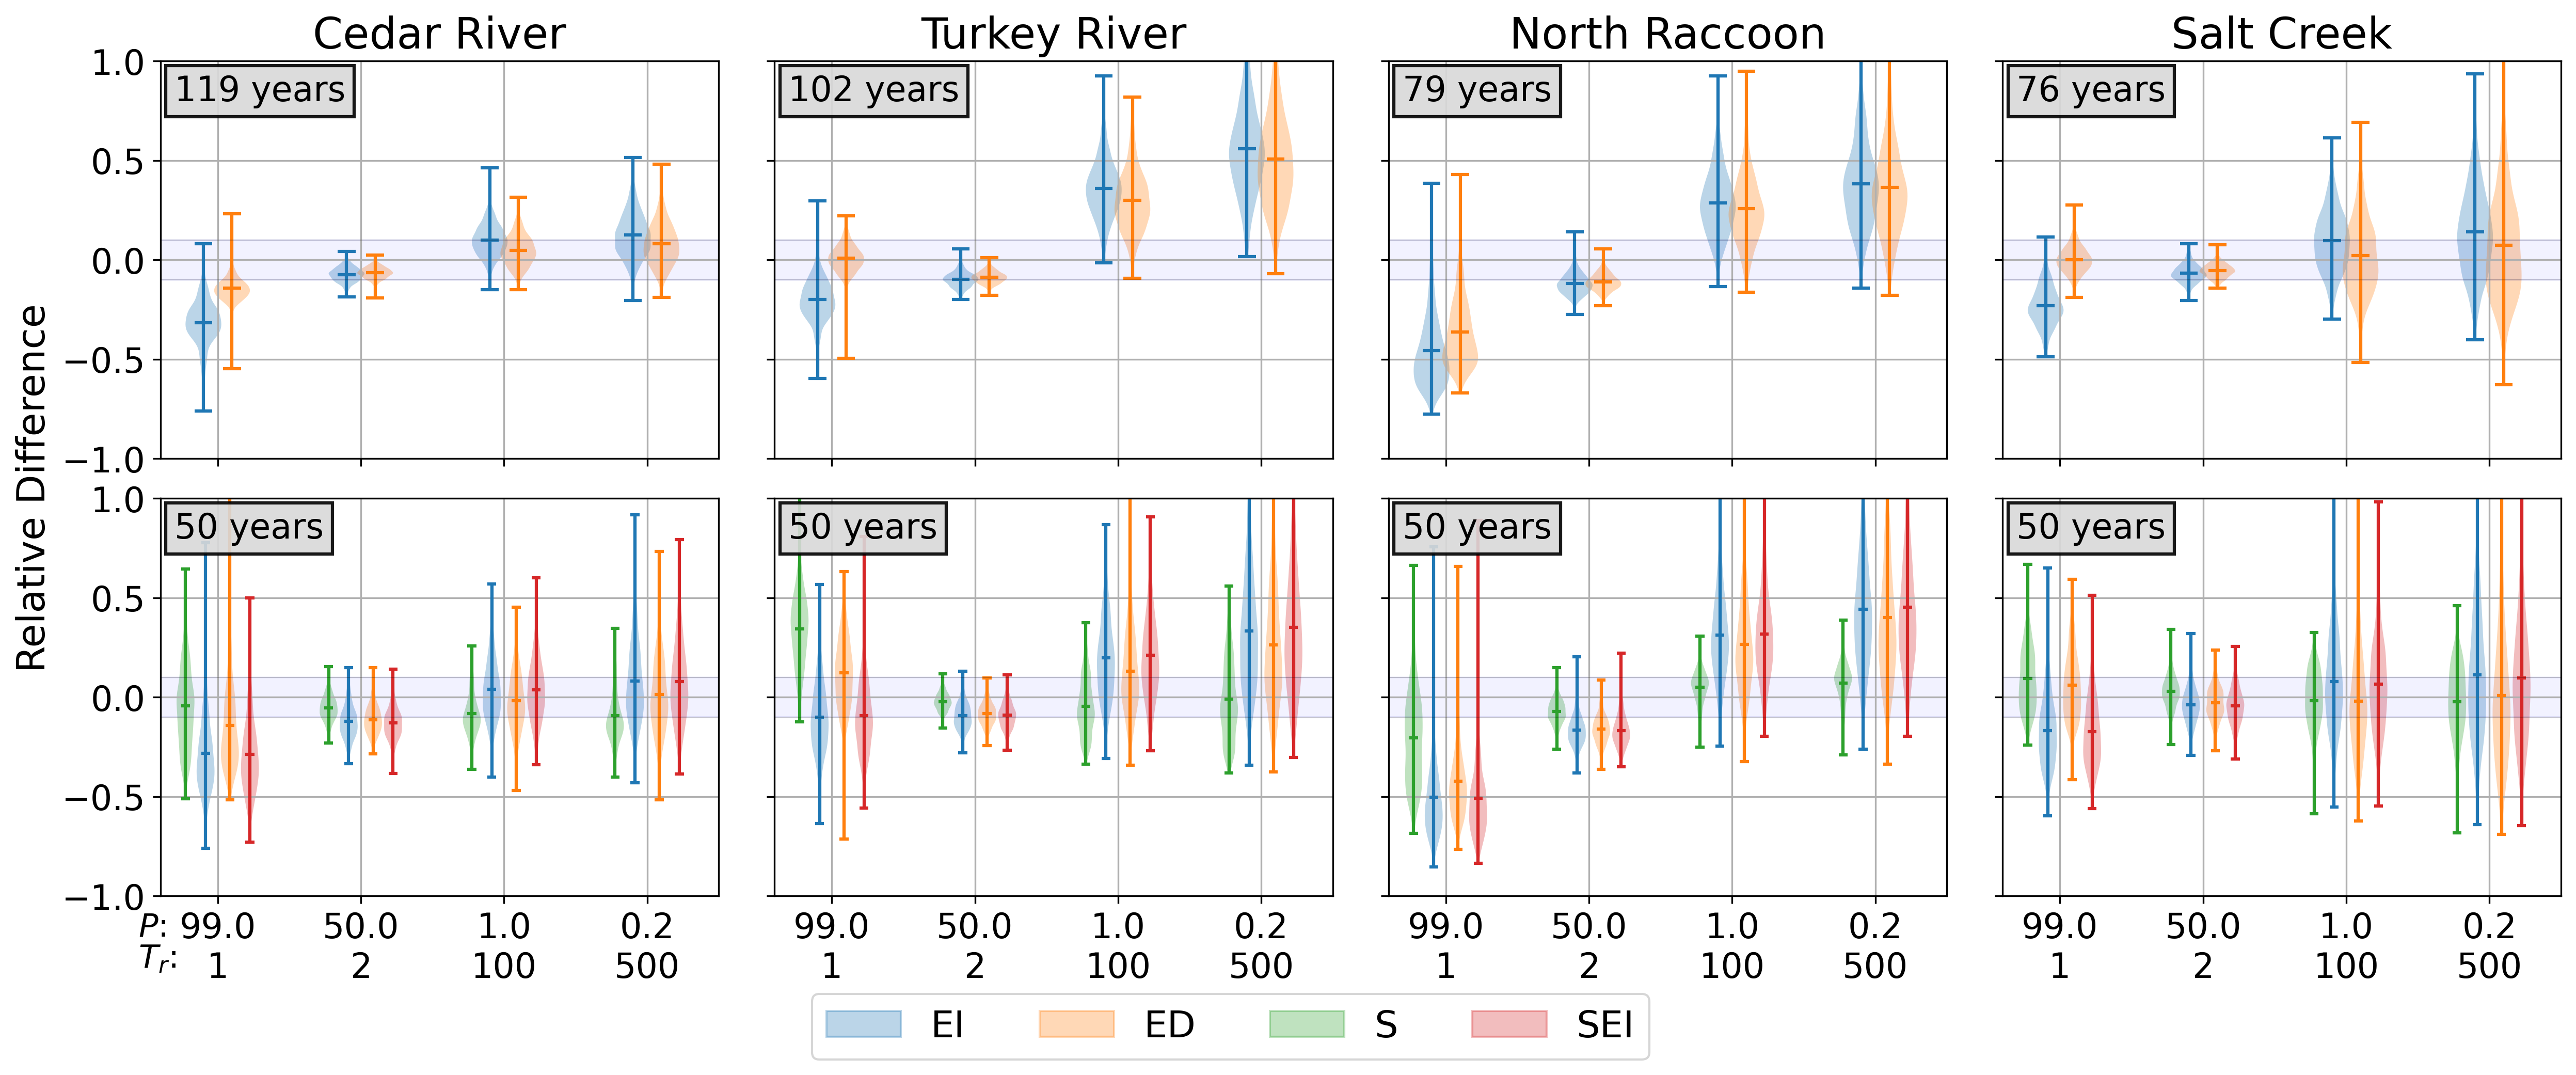

In [9]:
x = np.arange(0,8,2)
error = 0.1
labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

text = []
for p in [99.0,50,1,0.2]:
    pro = p
    Tr=1/(p/100)
    text.append('%.1f\n%d' % (pro, Tr))
    
fig, axes = pl.subplots(2,4,figsize = (20,7),  sharex=True, sharey=True, dpi = 300)

c = 0
for river, year in zip(['cedar','turkey','NorthRacoon', 'salt'],[119,102,79,76]):
    
    #Set the axes to plot at
    ax1 = axes[0,c]
    ax2 = axes[1,c]
    
    #Read the data
    a = np.load('data/processed/rel_diff_%s_%d.npz' % (river, year))
    b = np.load('data/processed/rel_diff_%s_50.npz' % (river))
    
    #Plot the violins for the total lenght of years
    vio1 = ax1.violinplot(a['EI'][:,[1,6,12,14]], showmeans = True, positions= x - 0.2)
    #add_label(vio1, 'Magnitude Independent')
    vio2 = ax1.violinplot(a['ED'][:,[1,6,12,14]], showmeans = True, positions= x + 0.2)
    #add_label(vio2, 'Magnitude Dependent')
    
    #Horizontal error bars
    ax1.hlines(error,-1,8,color = 'k',ls = '-',lw = 0.1)
    ax1.hlines(-error,-1,8,color = 'k',ls = '-',lw = 0.1)
    ax1.fill_between([-1,8],[-error,-error],[error,error], color = 'b',alpha = 0.05)
    
    ax1.set_title(rivers[river]['name'], size = 20)
    ax1.tick_params(labelsize = 16)
    ax1.set_ylim(-1,1)
    ax1.set_xlim(-0.8,7)
    ax1.set_xticks([0,2,4,6])
    ax1.grid()
    t = '%d years' % (year)
    ax1.text(0.025,0.9,t, fontdict = {'size': 16}, transform = ax1.transAxes,
            bbox=dict(facecolor='#d9d9d9', alpha=0.9, lw = 1.5))
    
    
    #Plot the violins for 50 years
    vio1 = ax2.violinplot(b['EI'][:,[1,6,12,14]], showmeans = True, positions= x - 0.17, widths = 0.25)
    add_label(vio1, 'EI')
    vio2 = ax2.violinplot(b['ED'][:,[1,6,12,14]], showmeans = True, positions= x + 0.17, widths = 0.25)
    add_label(vio2, 'ED')
    vio2 = ax2.violinplot(b['S'][:,[1,6,12,14]], showmeans = True, positions= x - 0.45, widths = 0.25)
    add_label(vio2, 'S')
    vio2 = ax2.violinplot(b['SEI'][:,[1,6,12,14]], showmeans = True, positions= x + 0.45, widths = 0.25)
    add_label(vio2, 'SEI')
    
    #Horizontal error bars
    ax2.hlines(error,-1,8,color = 'k',ls = '-',lw = 0.1)
    ax2.hlines(-error,-1,8,color = 'k',ls = '-',lw = 0.1)
    ax2.fill_between([-1,8],[-error,-error],[error,error], color = 'b',alpha = 0.05)
    
    ax2.tick_params(labelsize = 16)
    ax2.set_ylim(-1,1)
    ax2.set_xlim(-0.8,7)
    ax2.grid()
    ax2.set_xticks([0,2,4,6])
    t = '50 years'
    ax2.text(0.025,0.9,t, fontdict = {'size': 16}, transform = ax2.transAxes,
            bbox=dict(facecolor='#d9d9d9', alpha=0.9, lw = 1.5))
    ax2.set_xticklabels(text)
    if c == 0:
        ax2.legend(*zip(*labels), loc = 0, fontsize = 'xx-large', ncol = 4,
             bbox_to_anchor=(2.7, -0.2))
        ax2.set_ylabel('                                  Relative Difference', size = 18)
        ax2.text(-0.04, -0.10, '$P$:', fontdict={'size':15}, transform = ax2.transAxes,)
        ax2.text(-0.04, -0.18, '$T_r$:', fontdict={'size':15}, transform = ax2.transAxes)

    
    c+=1
        
pl.subplots_adjust(wspace = 0.1, hspace = 0.1)
pl.savefig('figures/Fig4_Relative_differences.png', bbox_inches = 'tight')

## Figure 5: Relative difference on the 5% confidence interval

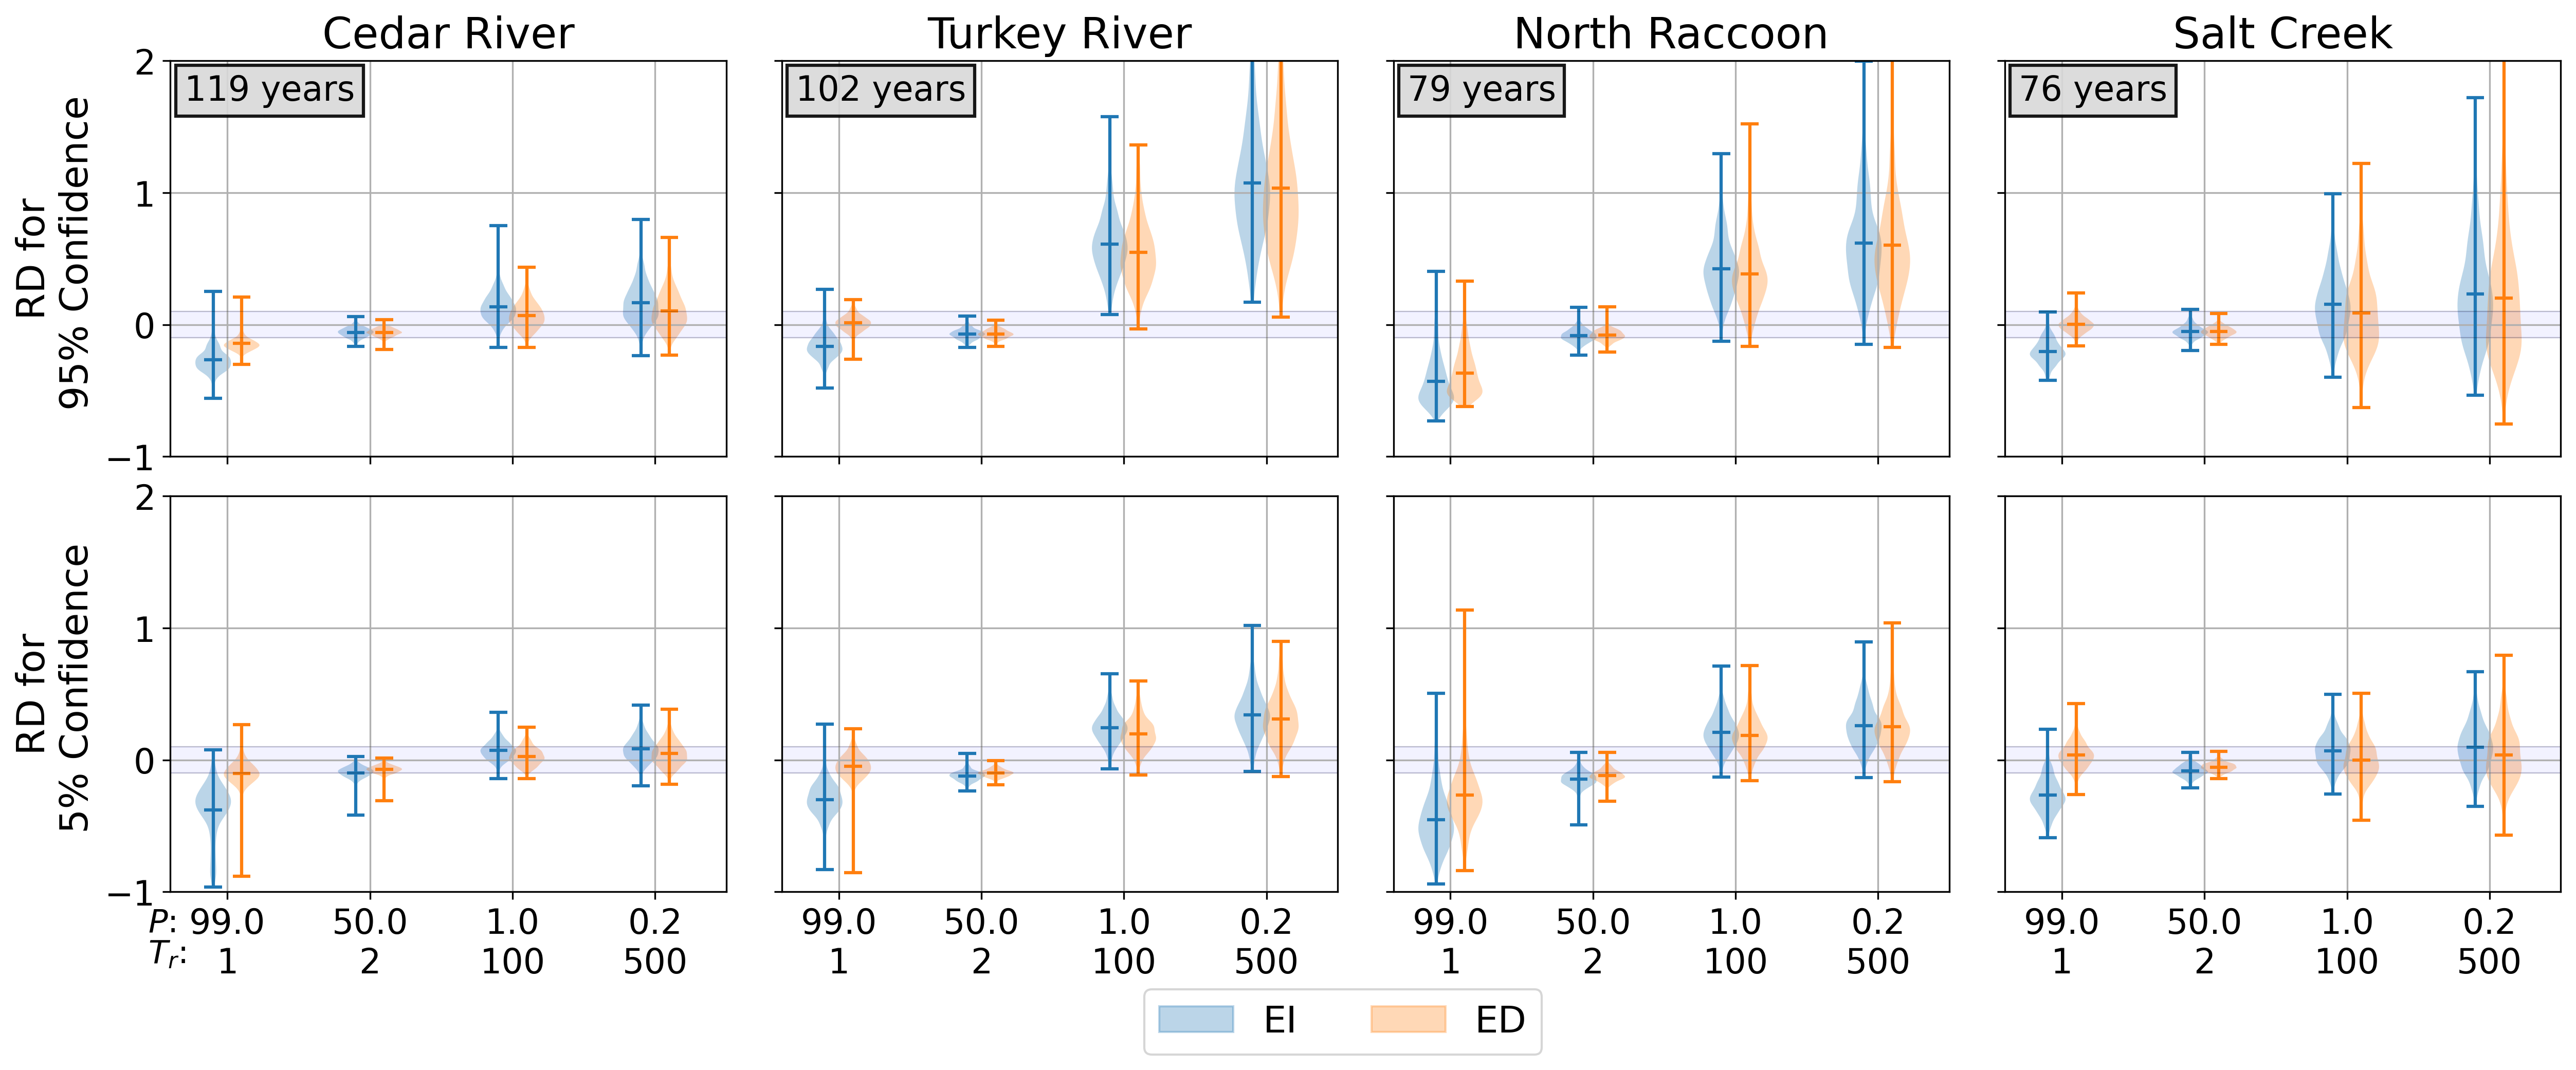

In [13]:
x = np.arange(0,8,2)
error = 0.1
labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

text = []
for p in [99.0,50,1,0.2]:
    pro = p
    Tr=1/(p/100)
    text.append('%.1f\n%d' % (pro, Tr))
    
fig, axes = pl.subplots(2,4,figsize = (20,7),  sharex=True, sharey=True, dpi = 300)

c = 0
for river, year in zip(['cedar','turkey','NorthRacoon', 'salt'],[119,102,79,76]):
    
    #Set the axes to plot at
    ax1 = axes[0,c]
    ax2 = axes[1,c]
    
    #Read the data
    a = np.load('data/processed/rel_diff_%s_c95%d.npz' % (river, year))
    b = np.load('data/processed/rel_diff_%s_c5%d.npz' % (river, year))
    
    #Plot the violins for the total lenght of years
    vio1 = ax1.violinplot(a['EI'][:,[1,6,12,14]], showmeans = True, positions= x - 0.2)
    #add_label(vio1, 'Magnitude Independent')
    vio2 = ax1.violinplot(a['ED'][:,[1,6,12,14]], showmeans = True, positions= x + 0.2)
    #add_label(vio2, 'Magnitude Dependent')
    
    #Horizontal error bars
    ax1.hlines(error,-1,8,color = 'k',ls = '-',lw = 0.1)
    ax1.hlines(-error,-1,8,color = 'k',ls = '-',lw = 0.1)
    ax1.fill_between([-1,8],[-error,-error],[error,error], color = 'b',alpha = 0.05)
    
    ax1.set_title(rivers[river]['name'], size = 20)
    ax1.tick_params(labelsize = 16)
    ax1.set_ylim(-1,2.5)
    ax1.set_xlim(-0.8,7)
    ax1.set_xticks([0,2,4,6])
    ax1.grid()
    if c == 0:
        ax1.set_ylabel('RD for\n {band}% Confidence'.format(**{'band':95}), size = 18)
    t = '%d years' % (year)
    ax1.text(0.025,0.9,t, fontdict = {'size': 16}, transform = ax1.transAxes,
            bbox=dict(facecolor='#d9d9d9', alpha=0.9, lw = 1.5))
    
    
    #Plot the violins for 50 years
    vio1 = ax2.violinplot(b['EI'][:,[1,6,12,14]], showmeans = True, positions= x - 0.2)
    add_label(vio1, 'EI')
    vio2 = ax2.violinplot(b['ED'][:,[1,6,12,14]], showmeans = True, positions= x + 0.2)
    add_label(vio2, 'ED')
    
    
    #Horizontal error bars
    ax2.hlines(error,-1,8,color = 'k',ls = '-',lw = 0.1)
    ax2.hlines(-error,-1,8,color = 'k',ls = '-',lw = 0.1)
    ax2.fill_between([-1,8],[-error,-error],[error,error], color = 'b',alpha = 0.05)
    
    ax2.tick_params(labelsize = 16)
    ax2.set_ylim(-1,2)
    ax2.set_xlim(-0.8,7)
    ax2.grid()
    ax2.set_xticks([0,2,4,6])
    ax2.set_xticklabels(text)
    
    if c == 0:
        ax2.set_ylabel('RD for\n {band}% Confidence'.format(**{'band':5}), size = 18)
        ax2.legend(*zip(*labels), loc = 0, fontsize = 'xx-large', ncol = 4,
             bbox_to_anchor=(2.5, -0.2))
        ax2.text(-0.04, -0.10, '$P$:', fontdict={'size':15}, transform = ax2.transAxes,)
        ax2.text(-0.04, -0.18, '$T_r$:', fontdict={'size':15}, transform = ax2.transAxes)

    
    c+=1
        
pl.subplots_adjust(wspace = 0.1, hspace = 0.1)
pl.savefig('figures/Fig5_Relative_differences_5-95percent_confidence.png', bbox_inches = 'tight')

## Figure 6: Comparing all scenarios 

Write a task file to process them all 

In [14]:
import glob 

In [15]:
list_files = glob.glob('data/sim/*')
f = open('task_all_vs_all', 'w')
for file in list_files:
    f.write('python compare_all_vs_all.py /Users/nicolas/FFE/%s\n' % file)
f.close()

### Analysis of the processed results 

Compute the probability of getting an error lower than 10% for each case and each river

In [16]:

for river in rivers.keys():
    for y in rivers[river]['years']:
        rivers[river].update({y:{}})
        list_files = glob.glob('data/processed/all_vs_all/%s_%dY*' % (river.upper(), y))
        for file in list_files:
            name = file.split('/')[-1].split('_')[-1][:-4]
            rd = np.load(file)['rd']
            p = []
            for i in range(15):
                a = np.abs(rd[:,i])        
                p.append(a[a<0.1].size / a.size)
            rivers[river][y].update({name:p})
            



Plot of that probability 

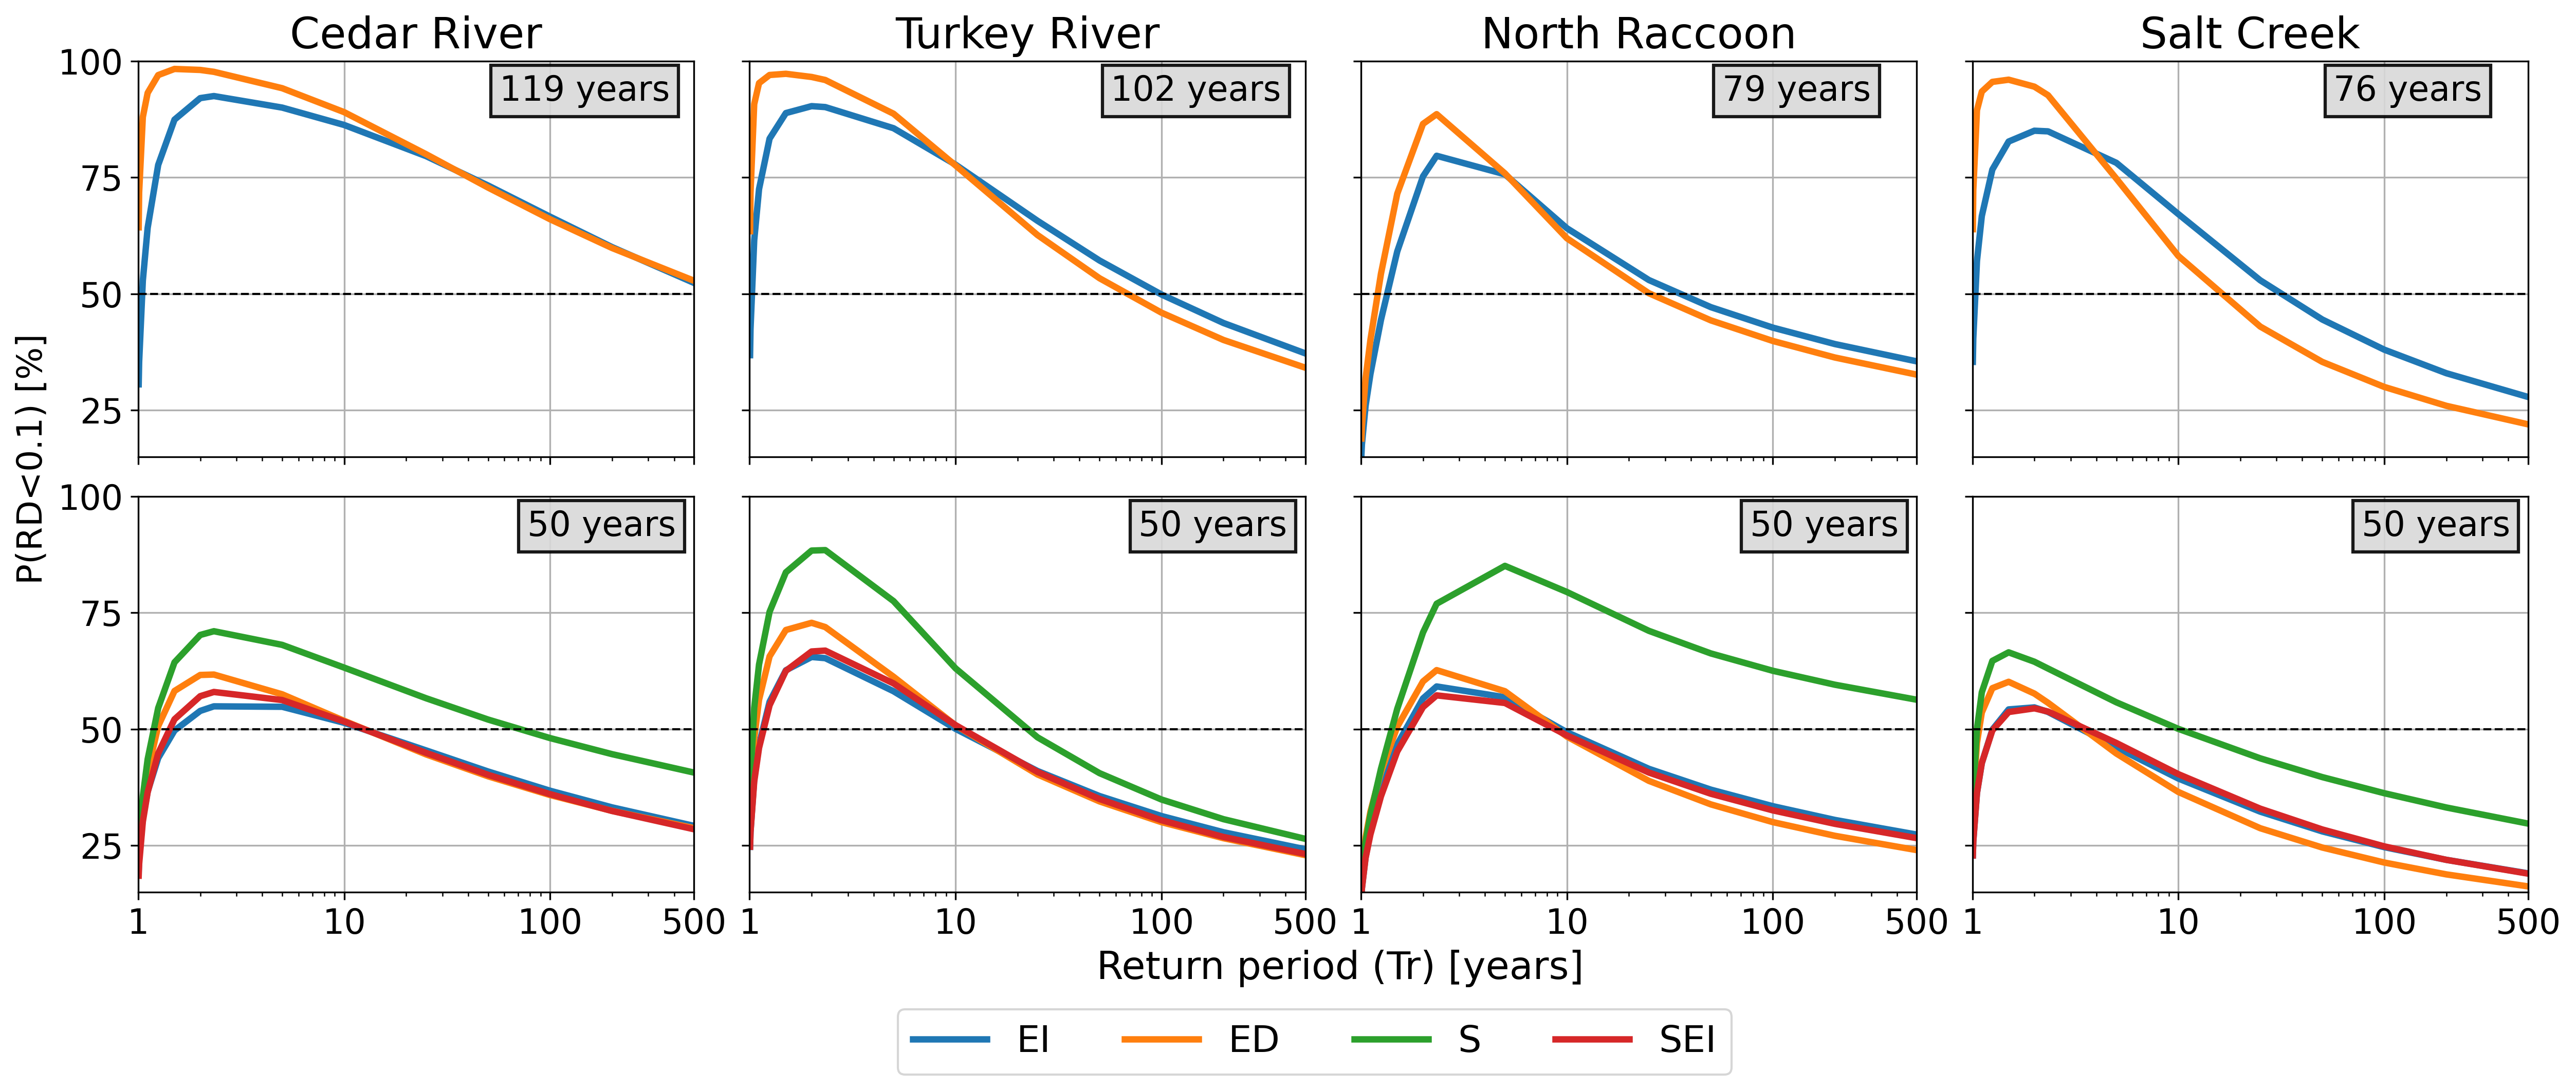

In [21]:
fig, axes = pl.subplots(2,4,figsize = (20,7),  sharex=True, sharey=True, dpi = 300)

d = pk.read_prt('data/05464500-CEDAR.PRT')[0]
Tr = 1/d['prob'].values

labels = {
    'EI':'Error Magnitude Independent',
    'ED':'Error Magnitude Dependent',
    'S':'Sampling',
    'SEI':'Sampling + Error'
}

for c1, river in enumerate(['cedar','turkey','NorthRacoon', 'salt']):
  
    y = rivers[river]['years'][0]
    for realization in ['EI','ED']:        
        axes[0,c1].plot(Tr, np.array(rivers[river][y][realization])*100, lw = 3)
    axes[0,c1].hlines(50,Tr[0], Tr[-1], ls = '--', lw = 1, color = 'k')
    axes[0,c1].tick_params(labelsize = 16)
    axes[0,c1].set_title(rivers[river]['name'], size = 20)
    #axes[0,c1].set_xticks(np.arange(0,15,2))
    axes[0,c1].set_xlim(Tr[0],Tr[-1])
    axes[0,c1].set_xscale('log')
    axes[0,c1].grid()
    axes[0,c1].set_ylim(15,100)
    axes[0,c1].set_yticks([25,50,75,100])    
    axes[0,c1].set_xticks([1e00, 1e01, 1e02, 500])
    axes[0,c1].set_xticklabels([1, 10, 100, 500])
    t = '%d years' % y
    axes[0,c1].text(0.65,0.9,t, fontdict = {'size': 16}, transform = axes[0,c1].transAxes,
            bbox=dict(facecolor='#d9d9d9', alpha=0.9, lw = 1.5))    
    
    y = rivers[river]['years'][1]
    for realization in ['EI','ED', 'S','SEI']:        
        axes[1,c1].plot(Tr,np.array(rivers[river][y][realization])*100, label = realization, lw = 3)
    axes[1,c1].hlines(50,Tr[0], Tr[-1], ls = '--', lw = 1, color = 'k')
    axes[1,c1].tick_params(labelsize = 16)
    if c1 == 1:
        axes[1,c1].legend( loc = 0, fontsize = 'xx-large', ncol = 4,
             bbox_to_anchor=(1.8, -0.25))
        axes[1,c1].set_xlabel('                                                   Return period (Tr) [years]', size = 18)
    if c1 == 0:
        axes[1,c1].set_ylabel('                                           P(RD<0.1) [$\%$]', size = 16)
        #axes[1,c1].text(-0.04, -0.10, '$P$:', fontdict={'size':15}, transform = ax2.transAxes,)
        #axes[1,c1].text(-0.04, -0.18, '$T_r$:', fontdict={'size':15}, transform = ax2.transAxes)
    axes[1,c1].grid()
    t = '50 years' 
    axes[1,c1].text(0.7,0.9,t, fontdict = {'size': 16}, transform = axes[1,c1].transAxes,
            bbox=dict(facecolor='#d9d9d9', alpha=0.9, lw = 1.5))
    
        
pl.subplots_adjust(wspace = 0.1, hspace = 0.1)
pl.savefig('figures/Fig6_all_vs_all_Prob_of_rel-erro_above_10.png', bbox_inches = 'tight')    